# PUNCHData guide
A notebook guide to working with PUNCHData FITS files in Python

This Jupyter Notebook presents a comprehensive guide to the analysis and visualization of PUNCHData FITS files using Python. The guide leverages a suite of Python libraries, including matplotlib for data visualization, numpy for numerical operations, astropy for FITS file handling and WCS manipulation, sunpy for solar data analysis, and ndcube for multi-dimensional data handling. The notebook serves as a robust resource for researchers and scientists, providing them with the tools and knowledge to effectively manipulate and interpret PUNCHData FITS files. The guide's step-by-step approach, coupled with code snippets and detailed explanations, ensures a user-friendly experience, promoting the accessibility of PUNCHData for a wider scientific community.

In [16]:
# Load libraries

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from copy import deepcopy

from astropy.io import fits
from astropy.wcs import WCS

import astropy.units as u

from sunpy.map import Map

from ndcube import NDCube

In [2]:
# Specify data filepath 

filename = 'PUNCH_L3_PAM_20240620000000.fits'

In [3]:
# Open the HDU list, and read out the appropriate data
# As the data is RICE compressed, the *second* HDU contains the main data frame

with fits.open(filename) as hdul:
    data = hdul[1].data
    header = hdul[1].header
    uncertainty = hdul[2].data

In [4]:
# Take a look at the data and uncertainty array shapes
# For this data product, total brightness and polarized brightness and stacked along the first dimension
# The uncertainty array corresponds on a pixel-to-pixel basis with the data array

data.shape, uncertainty.shape

((2, 4096, 4096), (2, 4096, 4096))

In [5]:
# Take a look at the header for these data

header

SIMPLE  = 'T       '           / Conforms to FITS Standard                      
BITPIX  =                  -32 / Number of bits per pixel                       
NAXIS   =                    3 / Number of axes                                 
NAXIS1  =                 4096 / Length of the first axis                       
NAXIS2  =                 4096 / Length of the second axis                      
NAXIS3  =                    2 / Length of the third axis                       
COMMENT ----- FITS Required ----------------------------------------------------
EXTNAME = 'PRIMARY DATA ARRAY' / Name of this binary table extension            
LONGSTRN= 'OGIP 1.0'           / The OGIP long string convention may be used    
COMMENT ----- Documentation, Contact, and Collection Metadata ------------------
DOI     = 'https://doi.org/TBD' / Data reference DOI                            
PROJECT = 'PUNCH   '                                                            
TITLE   = 'PUNCH Level-3 Pol

In [6]:
# The header information can be converted into an AstroPy WCS object
# Note that due to the stacked nature of this data, there is an additional STOKES axis

data_wcs = WCS(header);

data_wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-ARC' 'HPLT-ARC' 'STOKES' 
CRVAL : 0.0 0.0 0.0 
CRPIX : 2047.5 2047.5 0.0 
PC1_1 PC1_2 PC1_3  : 1.0 0.0 0.0 
PC2_1 PC2_2 PC2_3  : 0.0 1.0 0.0 
PC3_1 PC3_2 PC3_3  : 0.0 0.0 1.0 
CDELT : 0.0225 0.0225 1.0 
NAXIS : 4096  4096  2

In [7]:
# The secondary celestial WCS can be retrieved from metadata

data_wcs_celestial = WCS(header, key='A')

data_wcs_celestial

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---ARC' 'DEC--ARC' 'STOKES' 
CRVAL : 88.72529939915754 23.43076999917664 0.0 
CRPIX : 2047.5 2047.5 0.0 
PC1_1 PC1_2 PC1_3  : 0.9912781666299199 0.13178617667579878 0.0 
PC2_1 PC2_2 PC2_3  : -0.13178617667579878 0.9912781666299199 0.0 
PC3_1 PC3_2 PC3_3  : 0.0 0.0 1.0 
CDELT : -0.0225 0.0225 1.0 
NAXIS : 4096  4096  2

In [8]:
# Construct a SunPy Map object of out this primary brightness data

data_map = Map(data[0,:,:], header)

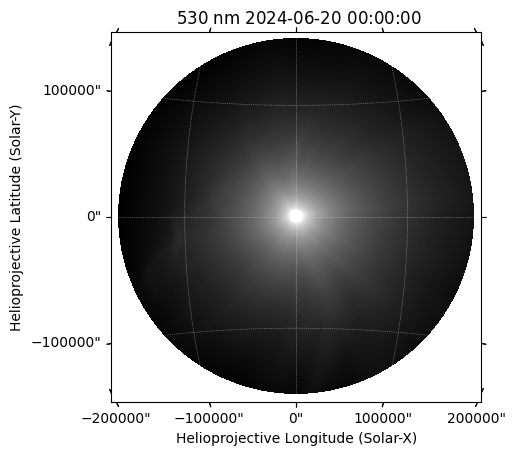

In [9]:
# Plot the data using the SunPy Map object plotting function

data_map.plot(norm='log')

In [10]:
# Construct an NDCube object out of the full data - brightness and polarized brightness

data_ndcube = NDCube(data, wcs=data_wcs, meta=header)

data_ndcube

NDCube
------
Dimensions: [2.000e+00 4.096e+03 4.096e+03] pix
Physical Types of Axes: [('phys.polarization.stokes',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: float32

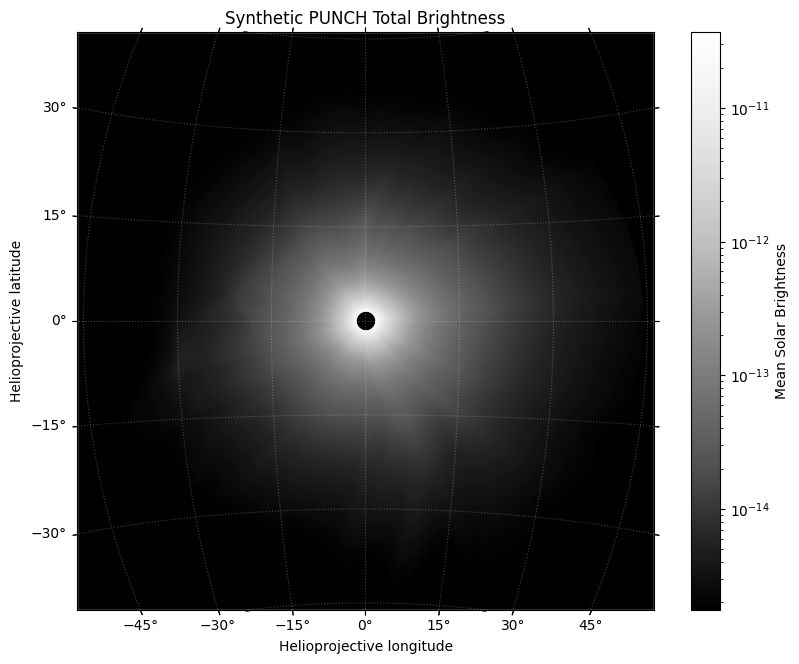

In [11]:
# Plot the data using matplotlib manually

plt.figure(figsize=(9.5, 7.5))
ax = plt.subplot(111, projection=data_wcs[0,:,:])
plt.imshow(data[0,:,:], cmap='Greys_r', norm=LogNorm(vmin=1.77e-15, vmax=3.7e-11))
lon, lat = ax.coords
lat.set_ticks(np.arange(-90, 90, 15) * u.degree)
lon.set_ticks(np.arange(-180, 180, 15) * u.degree)
lat.set_major_formatter('dd')
lon.set_major_formatter('dd')
ax.set_facecolor('black')
ax.coords.grid(color='white', alpha=.25, ls='dotted')
plt.xlabel("Helioprojective longitude")
plt.ylabel("Helioprojective latitude")
plt.title('Synthetic PUNCH Total Brightness')
plt.colorbar(label='Mean Solar Brightness')

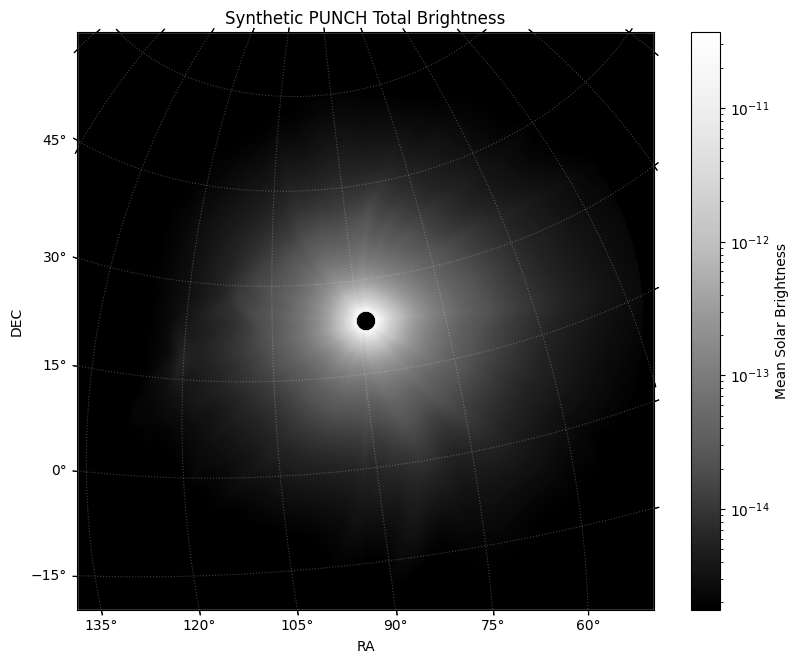

In [12]:
# Plot the data using matplotlib manually, using the celestial frame

plt.figure(figsize=(9.5, 7.5))
ax = plt.subplot(111, projection=data_wcs_celestial[0,:,:])
plt.imshow(data[0,:,:], cmap='Greys_r', norm=LogNorm(vmin=1.77e-15, vmax=3.7e-11))
lon, lat = ax.coords
lat.set_ticks(np.arange(-90, 90, 15) * u.degree)
lon.set_ticks(np.arange(-180, 180, 15) * u.degree)
lat.set_major_formatter('dd')
lon.set_major_formatter('dd')
ax.set_facecolor('black')
ax.coords.grid(color='white', alpha=.25, ls='dotted')
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title('Synthetic PUNCH Total Brightness')
plt.colorbar(label='Mean Solar Brightness')

In [13]:
# What if we wanted to reproject the data to a new arbitrary coordinate frame?
# First, define a new target WCS

new_wcs = deepcopy(data_map.wcs)

new_wcs.wcs.ctype = 'HPLN-ARC', 'HPLT-ARC'
new_wcs.wcs.cunit = 'deg', 'deg'
new_wcs.array_shape = 1024, 1024
new_wcs.wcs.crpix = 512, 512
new_wcs.wcs.crval = 10, 10
new_wcs.wcs.cdelt = 0.0225, 0.0225
new_wcs.wcs.pc = (0.66,-0.33), (0.33,0.66)

new_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-ARC' 'HPLT-ARC' 
CRVAL : 10.0 10.0 
CRPIX : 512.0 512.0 
PC1_1 PC1_2  : 0.66 -0.33 
PC2_1 PC2_2  : 0.33 0.66 
CDELT : 0.0225 0.0225 
NAXIS : 1024  1024

In [14]:
# We can reproject using SunPy maps

new_map = data_map.reproject_to(new_wcs)

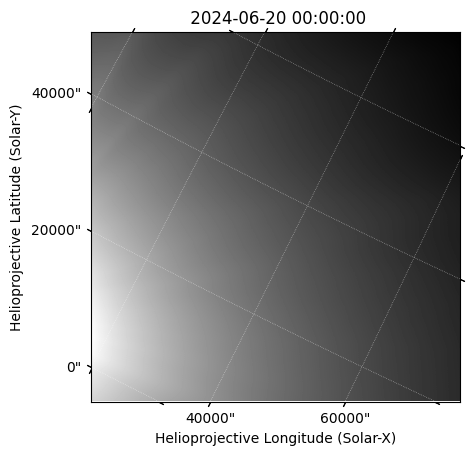

In [15]:
# Plot this reprojected map

new_map.plot(norm='log')